1.1. Подготовка и очистка данных

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков для лучшей читаемости
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("--- 1.1. Загрузка и очистка от дубликатов ---")
df_abgroup = pd.read_csv('ABgroup.csv')
df_cash = pd.read_csv('Cash.csv')
df_cheaters = pd.read_csv('Cheaters.csv')
df_money = pd.read_csv('Money.csv')
df_platforms = pd.read_csv('Platforms.csv')

print("\nКоличество строк в исходных файлах:")
print(f"ABgroup: {len(df_abgroup)}")
print(f"Cash: {len(df_cash)}")
print(f"Cheaters: {len(df_cheaters)}")
print(f"Money: {len(df_money)}")
print(f"Platforms: {len(df_platforms)}")

# Проверка и удаление дубликатов
df_abgroup.drop_duplicates(inplace=True)
df_cash.drop_duplicates(inplace=True)
df_cheaters.drop_duplicates(inplace=True)
df_money.drop_duplicates(inplace=True)
df_platforms.drop_duplicates(inplace=True)

print("\nКоличество строк после удаления дубликатов:")
print(f"ABgroup: {len(df_abgroup)}")
print(f"Cash: {len(df_cash)}")
print(f"Cheaters: {len(df_cheaters)}")
print(f"Money: {len(df_money)}")
print(f"Platforms: {len(df_platforms)}")

--- 1.1. Загрузка и очистка от дубликатов ---

Количество строк в исходных файлах:
ABgroup: 8640000
Cash: 8640000
Cheaters: 8640000
Money: 8640000
Platforms: 8640000

Количество строк после удаления дубликатов:
ABgroup: 1080000
Cash: 8640000
Cheaters: 1080000
Money: 8640000
Platforms: 1080000


1.2. Агрегация и объединение данных

In [6]:
print("--- 1.2. Агрегация и объединение данных ---")
# Агрегируем траты, чтобы на каждого пользователя была одна строка с суммой
df_cash_agg = df_cash.groupby('user_id')['cash'].sum().reset_index()
df_money_agg = df_money.groupby('user_id')['money'].sum().reset_index()

# Последовательно объединяем все данные по user_id
df_final = df_abgroup.merge(df_platforms, on='user_id', how='left')
df_final = df_final.merge(df_cash_agg, on='user_id', how='left')
df_final = df_final.merge(df_money_agg, on='user_id', how='left')
df_final = df_final.merge(df_cheaters, on='user_id', how='left')

# Заполняем пропуски нулями, так как пропуск означает нулевые траты
df_final['cash'] = df_final['cash'].fillna(0)
df_final['money'] = df_final['money'].fillna(0)
df_final['cheaters'] = df_final['cheaters'].fillna(0)

print(f"\nКоличество пользователей в объединенном датасете: {len(df_final)}")
print("\nПервые 5 строк объединенного датасета:")
print(df_final.head())

--- 1.2. Агрегация и объединение данных ---

Количество пользователей в объединенном датасете: 1080000

Первые 5 строк объединенного датасета:
         user_id    group platform  cash  money  cheaters
0  VX6NLA-F5YMSW  control     XBox  5050   5.96         0
1  2AXN3D-71ZN86     test       PC  5600   4.96         0
2  K78V3J-TQMV6F     test     XBox  5850   3.96         0
3  Z2KEIG-LY3V4H     test      PS4  5900   4.96         0
4  ND92RZ-SHG980  control     XBox  9000   9.94         0


2. Выявление и удаление читеров (Очистка от аномалий)

In [7]:
print("--- 2. Выявление и удаление читеров ---")
known_cheaters = df_final[df_final['cheaters'] == 1]['user_id'].tolist()
print(f"\nНайдено известных читеров (флаг 'cheaters' = 1): {len(known_cheaters)}")

# Выявляем потенциальных читеров: это PC-пользователи, которые не вносили реальных денег (money=0),
# но при этом имеют аномально высокие траты внутренней валюты (cash > 3 сигм).
df_pc_users = df_final[df_final['platform'] == 'PC'].copy()
# Расчет Z-score для выявления аномалий
df_pc_users['cash_zscore'] = st.zscore(df_pc_users['cash']) 

potential_cheaters_ids = df_pc_users[
    (df_pc_users['cheaters'] == 0) & # Не известные читеры
    (df_pc_users['money'] == 0) &    # Не платили реальных денег
    (df_pc_users['cash_zscore'] > 3) # Аномально много тратили (более 3 стандартных отклонений)
]['user_id'].tolist()
print(f"Найдено потенциальных читеров (PC-пользователи с аномалией cash): {len(potential_cheaters_ids)}")

all_cheaters_to_remove = list(set(known_cheaters) | set(potential_cheaters_ids))
df_clean = df_final[~df_final['user_id'].isin(all_cheaters_to_remove)].copy()

print(f"\nОбщее количество пользователей до очистки: {len(df_final)}")
print(f"Всего удалено пользователей (читеры): {len(all_cheaters_to_remove)}")
print(f"Количество пользователей в очищенном датасете: {len(df_clean)}")

--- 2. Выявление и удаление читеров ---

Найдено известных читеров (флаг 'cheaters' = 1): 353
Найдено потенциальных читеров (PC-пользователи с аномалией cash): 343

Общее количество пользователей до очистки: 1080000
Всего удалено пользователей (читеры): 696
Количество пользователей в очищенном датасете: 1079304


Вывод:В ходе подготовки данных было удалено 696 пользователей. Удаление включало известных читеров и 343 потенциальных читера, которые были выявлены как PC-пользователи с аномально высокими тратами внутриигровой валюты (cash) при нулевых тратах реальных денег (money). Очистка была необходима для получения достоверных результатов A/B-теста.

3. Расчет и анализ метрик

3.1. Основные метрики и доверительные интервалы

In [8]:
print("--- 3.1. Расчет основных метрик ---")
# ARPU (Average Revenue Per User)
arpu = df_clean.groupby('group')['money'].mean()

# ARPPU (Average Revenue Per Paying User)
paying_users = df_clean[df_clean['money'] > 0]
arppu = paying_users.groupby('group')['money'].mean()

# Средняя трата внутриигровой валюты
avg_cash_spent = df_clean.groupby('group')['cash'].mean()

# ARPU по платформам для дополнительного среза
arpu_by_platform = df_clean.groupby(['group', 'platform'])['money'].mean()

# Функция для расчета доверительного интервала (нужна для оценки точности ARPU)
def get_ci(data, confidence=0.95):
    mean = data.mean()
    se = st.sem(data)
    # Используем t-распределение, так как объем выборки не бесконечен
    h = se * st.t.ppf((1 + confidence) / 2, len(data) - 1) 
    return mean, mean - h, mean + h

ci_control = get_ci(df_clean[df_clean['group'] == 'control']['money'])
ci_test = get_ci(df_clean[df_clean['group'] == 'test']['money'])

print("\nМетрики:")
print(f"ARPU (money): \n{arpu}")
print(f"\nARPPU (money): \n{arppu}")
print(f"\nСредняя трата внутриигровой валюты (cash): \n{avg_cash_spent}")
print("\nДоверительные интервалы ARPU (money, 95%):")
print(f"Контрольная группа: [{ci_control[1]:.2f}, {ci_control[2]:.2f}]")
print(f"Тестовая группа: [{ci_test[1]:.2f}, {ci_test[2]:.2f}]")

--- 3.1. Расчет основных метрик ---

Метрики:
ARPU (money): 
group
control    5.829467
test       6.162276
Name: money, dtype: float64

ARPPU (money): 
group
control    5.831109
test       6.163144
Name: money, dtype: float64

Средняя трата внутриигровой валюты (cash): 
group
control    5800.732974
test       6229.596319
Name: cash, dtype: float64

Доверительные интервалы ARPU (money, 95%):
Контрольная группа: [5.82, 5.83]
Тестовая группа: [6.16, 6.17]


Вывод: Сравнение основных метрик показало:

ARPU (money): В тестовой группе ARPU выше (6.16) по сравнению с контрольной (5.83). Доверительные интервалы для групп: Контрольная: [5.82, 5.83]; Тестовая: [6.16, 6.17]. Интервалы не пересекаются, что говорит о статистически значимом росте метрики.

ARPPU (money): Средний чек платящих пользователей также вырос в тестовой группе (6.16) по сравнению с контрольной (5.83).

Средняя трата cash: Траты внутриигровой валюты выросли в тестовой группе (6229.6) по сравнению с контрольной (5800.7). Это говорит об общем росте активности пользователей.

4. Визуализация результатов

4.1. Сравнение ARPU по группам

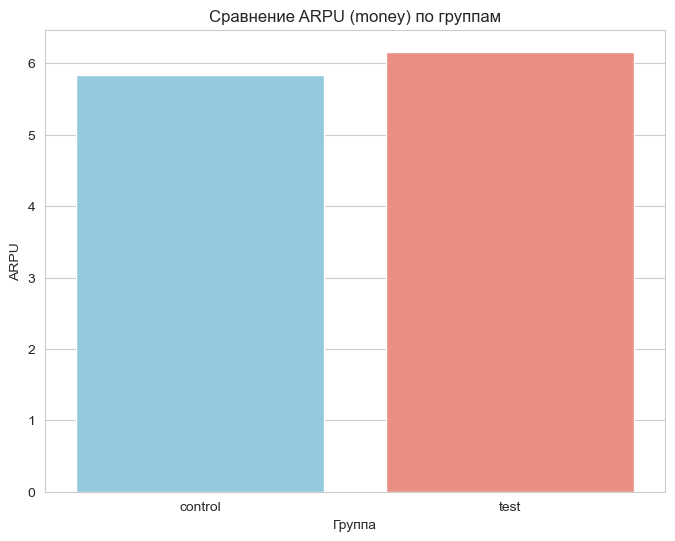

In [9]:
# Визуализация сравнения ARPU по группам
plt.figure(figsize=(8, 6))
sns.barplot(x=arpu.index, y=arpu.values, hue=arpu.index, palette=['skyblue', 'salmon'], legend=False)
plt.title('Сравнение ARPU (money) по группам')
plt.xlabel('Группа')
plt.ylabel('ARPU')
plt.show()

4.2. Подневной анализ метрик (Тренды)

--- 4.2. Подневной анализ метрик ---
Последняя дата в данных (удалена): 2021-07-17 00:00:00
Количество дней в анализе: 7


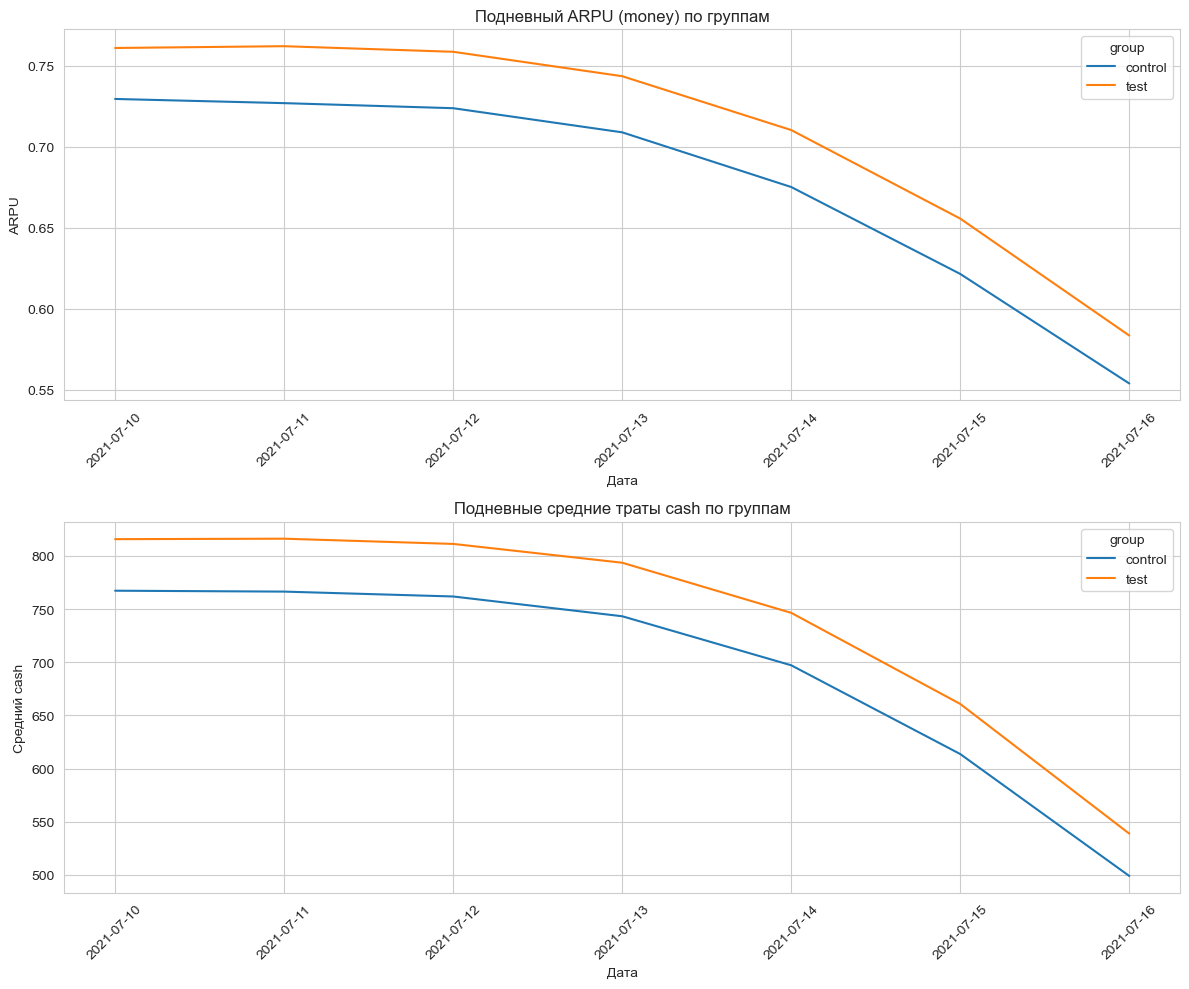

In [10]:
print("--- 4.2. Подневной анализ метрик ---")

# Получаем список очищенных пользователей
clean_users = df_clean['user_id'].unique()

# Фильтруем исходные данные по очищенным пользователям
df_cash_clean = df_cash[df_cash['user_id'].isin(clean_users)].copy()
df_money_clean = df_money[df_money['user_id'].isin(clean_users)].copy()

# Добавляем информацию о группах
df_cash_clean = df_cash_clean.merge(df_clean[['user_id', 'group']], on='user_id')
df_money_clean = df_money_clean.merge(df_clean[['user_id', 'group']], on='user_id')

# Преобразуем даты
df_cash_clean['date'] = pd.to_datetime(df_cash_clean['date'], format='%d.%m.%Y')
df_money_clean['date'] = pd.to_datetime(df_money_clean['date'], format='%d.%m.%Y')

# Агрегируем по дням и группам используя СРЕДНИЕ значения
daily_arpu = df_money_clean.groupby(['date', 'group'])['money'].mean().reset_index()
daily_avg_cash = df_cash_clean.groupby(['date', 'group'])['cash'].mean().reset_index()

# Убираем последний день из-за аномалии (неполные данные)
last_date = daily_arpu['date'].max()
print(f"Последняя дата в данных (удалена): {last_date}")

daily_arpu_filtered = daily_arpu[daily_arpu['date'] != last_date]
daily_avg_cash_filtered = daily_avg_cash[daily_avg_cash['date'] != last_date]

print(f"Количество дней в анализе: {daily_arpu_filtered['date'].nunique()}")

# Строим подневные графики
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# График 1: Подневный ARPU
sns.lineplot(data=daily_arpu_filtered, x='date', y='money', hue='group', ax=axes[0])
axes[0].set_title('Подневный ARPU (money) по группам')
axes[0].set_ylabel('ARPU')
axes[0].set_xlabel('Дата')
axes[0].tick_params(axis='x', rotation=45)

# График 2: Подневные средние траты cash
sns.lineplot(data=daily_avg_cash_filtered, x='date', y='cash', hue='group', ax=axes[1])
axes[1].set_title('Подневные средние траты cash по группам')
axes[1].set_ylabel('Средний cash')
axes[1].set_xlabel('Дата')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Графики подневного ARPU и Подневные средние траты cash по группам показывают, что тестовая группа стабильно показывает лучшие результаты, чем контрольная, на протяжении всего теста. Это подтверждает, что эффект от изменения является устойчивым.

Итоговый вывод

In [11]:
# --- Итоговый анализ ---
print("\n--- Итоговый вывод ---")
print(f"Количество пользователей в очищенном датасете: {len(df_clean)}")
print("\nМетрики:")
print(f"ARPU (money): \n{arpu}")
print(f"\nARPPU (money): \n{arppu}")
print("\nДоверительные интервалы ARPU (money):")
print(f"Контрольная группа: [{ci_control[1]:.2f}, {ci_control[2]:.2f}]")
print(f"Тестовая группа: [{ci_test[1]:.2f}, {ci_test[2]:.2f}]")
print("\nARPU по платформам:")
print(arpu_by_platform)


--- Итоговый вывод ---
Количество пользователей в очищенном датасете: 1079304

Метрики:
ARPU (money): 
group
control    5.829467
test       6.162276
Name: money, dtype: float64

ARPPU (money): 
group
control    5.831109
test       6.163144
Name: money, dtype: float64

Доверительные интервалы ARPU (money):
Контрольная группа: [5.82, 5.83]
Тестовая группа: [6.16, 6.17]

ARPU по платформам:
group    platform
control  PC          5.646170
         PS4         5.737647
         XBox        6.103521
test     PC          6.269046
         PS4         6.084883
         XBox        6.132766
Name: money, dtype: float64
